In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Process Data

In [43]:
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

In [44]:
indices_train = np.where((y_train_full == 4) | (y_train_full == 5))
indices_test = np.where((y_test == 4) | (y_test == 5))
x_train_filtered = x_train_full[indices_train]
y_train_filtered = y_train_full[indices_train]
x_test_filtered = x_test[indices_test]
y_test_filtered = y_test[indices_test]

In [45]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_filtered.reshape(-1, 784)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(x_test_filtered.reshape(-1, 784)).reshape(-1, 28, 28, 1)

In [46]:
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train_filtered, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [47]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (10800, 28, 28, 1)
Shape of x_val: (600, 28, 28, 1)
Shape of x_test: (600, 28, 28, 1)


# Show Example IMG

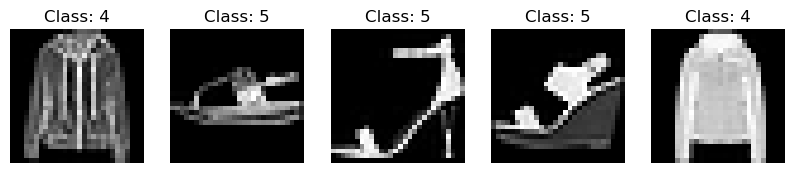

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Class: {y_train[i]}')
    plt.axis('off')
plt.show()

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

# Baseline Model

In [50]:
# input_img = Input(shape=(784,))
# encoded = Dense(128, activation='relu')(input_img)
# decoded = Dense(784, activation='sigmoid')(encoded)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

In [51]:
# Defining the architecture
def build_autoencoder(input_shape, latent_dim):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    latent_space = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(14*14*32, activation='relu')(latent_space)
    x = Reshape((14, 14, 32))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

# Defining dimensions and building the model
input_shape = (28, 28, 1)
latent_dim = 128
autoencoder = build_autoencoder(input_shape, latent_dim)

# Summary of the model
autoencoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Training the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3609 - val_loss: 0.2720
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2635 - val_loss: 0.2611
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2537 - val_loss: 0.2556
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2492 - val_loss: 0.2521
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2458 - val_loss: 0.2489
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2416 - val_loss: 0.2472
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2407 - val_loss: 0.2458
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2406 - val_loss: 0.2445
Epoch 9/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2394 - val_loss: 0.2445
Epoch 10/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2374 - val_loss: 0.2438


In [53]:
# Evaluating SSIM on test data with data_range parameter
def evaluate_ssim(autoencoder, x_test):
    x_decoded = autoencoder.predict(x_test)
    ssim_scores = []
    for i in range(len(x_test)):
        ssim_score = ssim(x_test[i].reshape(28, 28), x_decoded[i].reshape(28, 28), data_range=1.0)
        ssim_scores.append(ssim_score)
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

avg_ssim = evaluate_ssim(autoencoder, x_test)
print(f'Average SSIM on test set: {avg_ssim}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Average SSIM on test set: 0.8523384092766884


# Modified Model

In [54]:
from tensorflow.keras.layers import BatchNormalization

In [76]:
# Defining the architecture
def build_autoencoder_opt(input_shape, latent_dim):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    latent_space = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(14*14*64, activation='relu')(latent_space)
    x = Reshape((14, 14, 64))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

# Defining dimensions and building the model
input_shape = (28, 28, 1)
latent_dim = 256
autoencoder_opt = build_autoencoder_opt(input_shape, latent_dim)

# Summary of the model
autoencoder_opt.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 12544)          │     3,223,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,849,281 (18.50 MB)

 Trainable params: 4,849,025 (18.50 MB)

 Non-trainable params: 256 (1.00 KB)

In [77]:
autoencoder_opt.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.3381 - val_loss: 0.3795
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2534 - val_loss: 0.2527
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2445 - val_loss: 0.2482
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2406 - val_loss: 0.2444
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2393 - val_loss: 0.2423
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2359 - val_loss: 0.2432
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2361 - val_loss: 0.2411
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2355 - val_loss: 0.2400
Epoch 9/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2321 - val_loss: 0.2394
Epoch 10/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2320 - val_loss: 0.2390
Epoch 11/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2309 - val_loss: 0.2392
Epoch 12/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 

In [78]:
avg_ssim_opt = evaluate_ssim(autoencoder_opt, x_test)
print(f'Average SSIM on test set (modified): {avg_ssim_opt}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Average SSIM on test set (modified): 0.902643186176845


In [79]:
diff = ((avg_ssim_opt-avg_ssim)/avg_ssim) *100
print(f"{diff:.2f}%")
print(avg_ssim)
print(avg_ssim_opt)

5.90%
0.8523384092766884
0.902643186176845
